<h1><center> Channel Clustering Algorithm </center></h1>

In [3]:
from ast import literal_eval
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.spatial.distance import euclidean as dist
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
import xml.etree.ElementTree as ET
import os
from collections import OrderedDict

from IPython.display import Image

%matplotlib inline



In [4]:
path2save = '/Users/vrhaynes/Desktop/research/data_analysis/meta/NeuroMLDBTools/data'
path2models = os.path.join(path2save,'models')
path2ephys = os.path.join(path2save,'ephys')
path2images = '/Users/vrhaynes/Desktop/research/data_analysis/meta/NeuroMLDBTools/images'



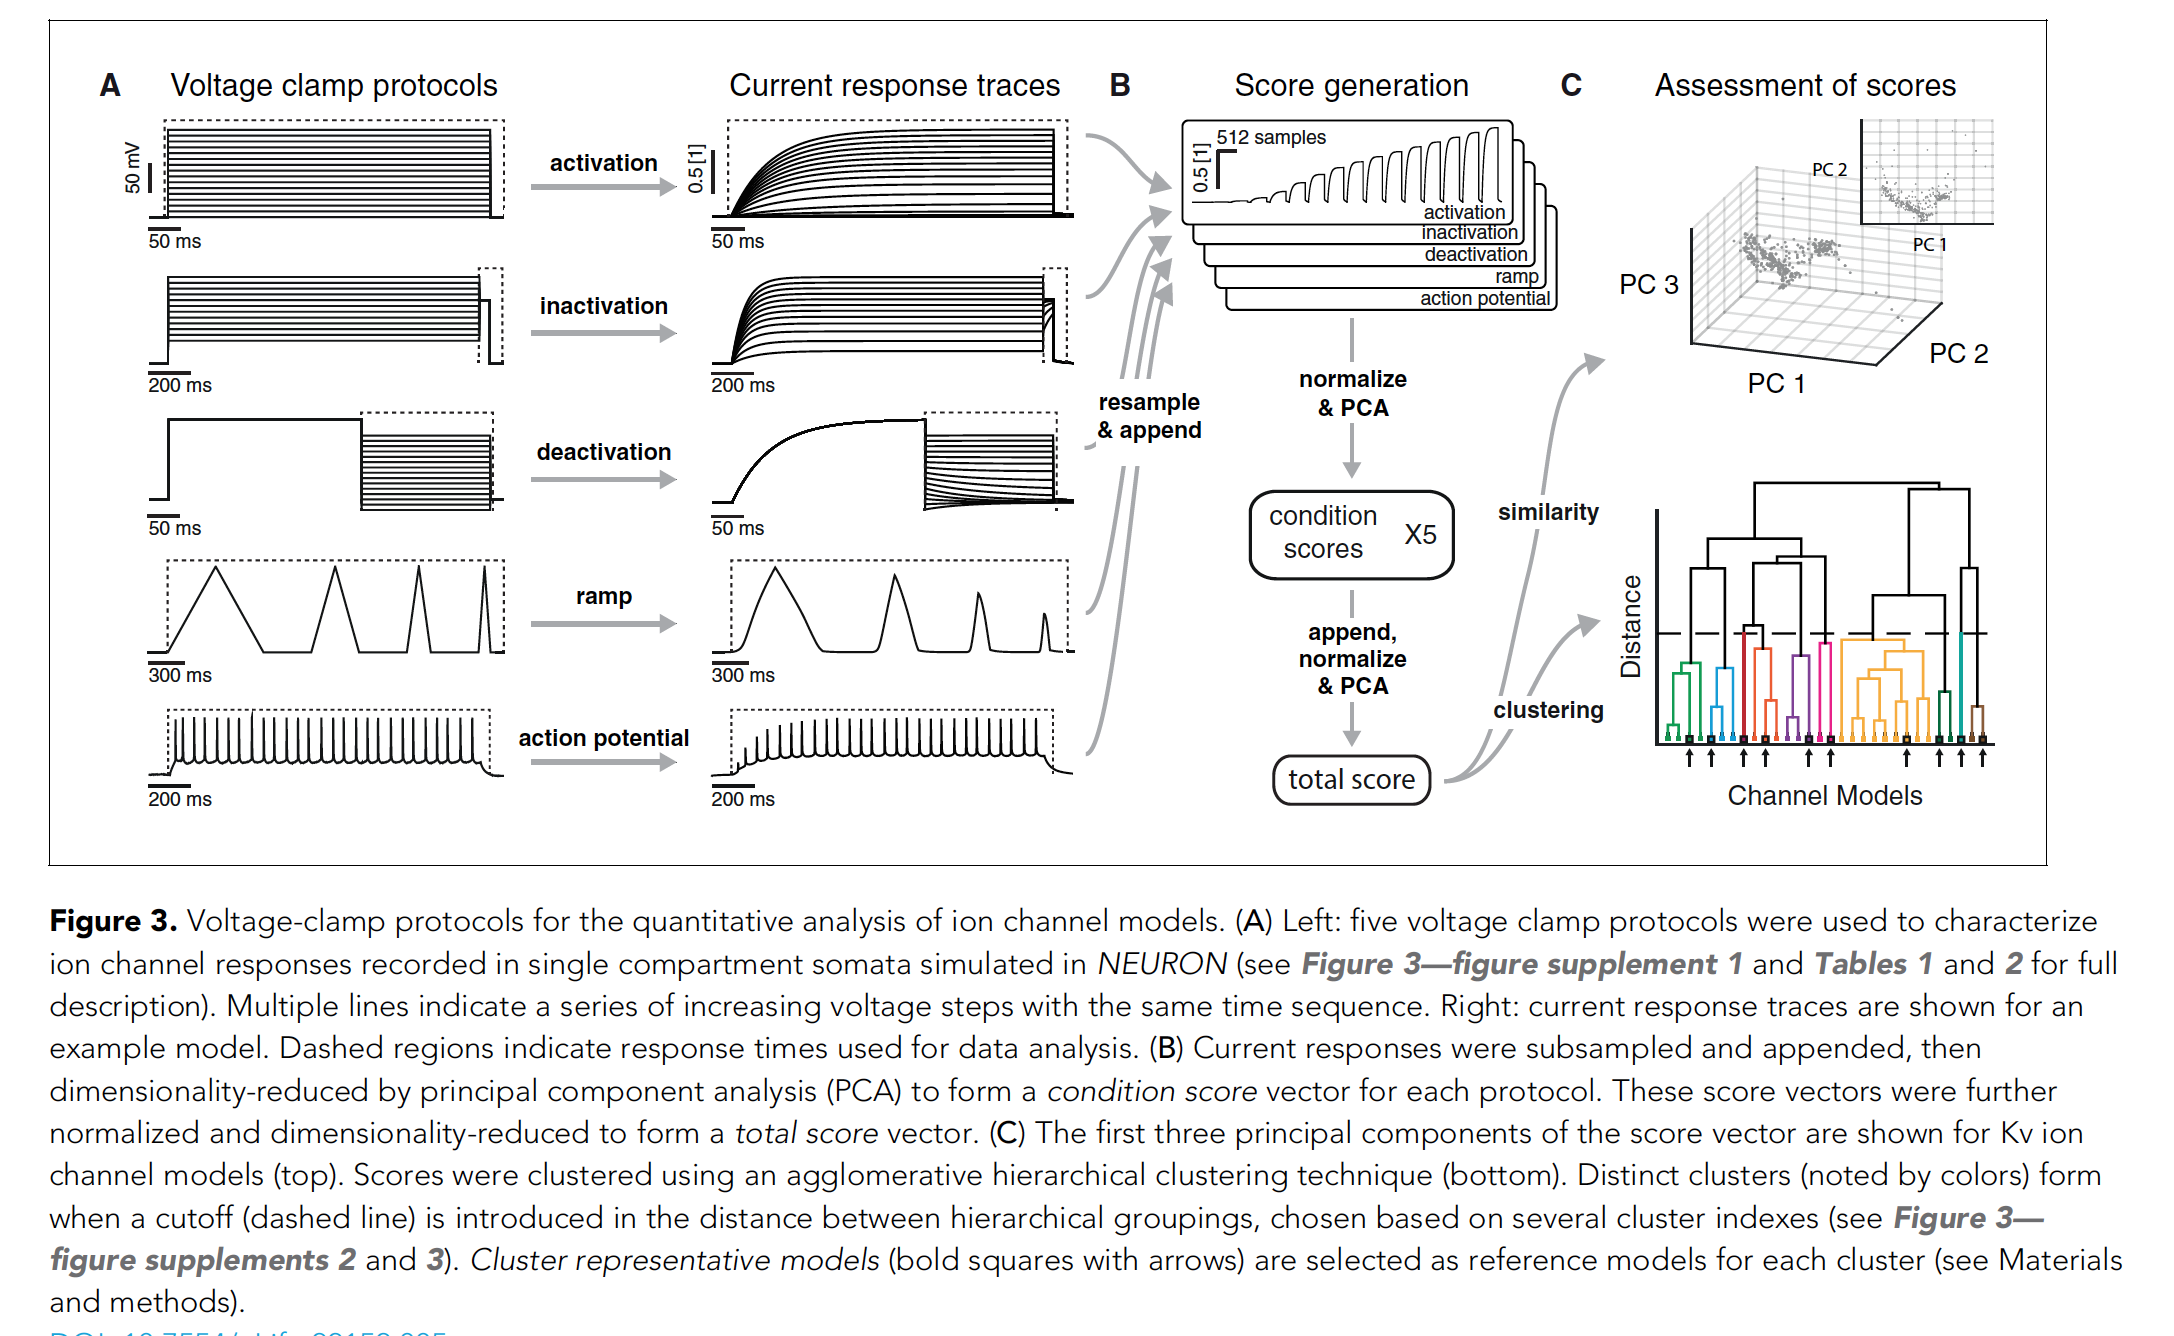

In [5]:
# Figure 3 - Podlaski et al. (2017)
filename = os.path.join(path2images,'icgen_clustering_algorithm.png')
Image(filename)



From Podlaski et al. (2017)

>"To this end, the subsampled and appended current
responses for each protocol across all N channels in a family yielded a NxL dimensional data matrix,
in which we normalized each column by Z-scoring: we subtracted its mean and then divided by its
standard deviation. This matrix was then dimensionality reduced by PCA across the L temporal
entries, where we chose the reduced dimensionality to capture 99% of the variability. To normalize
the range of scores across conditions while keeping the covariance structure, we divided the score
vector of each protocol by the standard deviation of all score entries of this protocol. These normalized scores (denoted by condition scores) were then combined into a final score vector. <b>Further correlations across protocols were removed by again dimensionality-reducing by PCA (99% variance
criterion) to yield a final score vector for each model.</b> Since response traces were relatively noise-
free, a high PCA dimensionality can be chosen to capture current response dimensions that are rare
across the population of models."

Maybe they mean to say that each set of condition scores corresponding to their respective protocols are combined into a NxP matrix, where N is the number of channel models and P is the number of protocols. Then this NxP matrix is then reduced to an Nx1 vector containing the final scores using PCA.

In [4]:
# load if already saved dataframes
filename = os.path.join(path2save,'channel_tags.csv')
channel_tags_df = pd.read_csv(filename)

filename = os.path.join(path2save,'current_responses.pkl')
current_responses_df = pd.read_pickle(filename)

filename = os.path.join(path2save,'appended_responses.pkl')
appended_responses_df = pd.read_pickle(filename)



In [5]:
def normalize_responses(channel_pca_df,num_identifiers=3):
    '''
        Corrects for differences in maximal conductance and inward/outward differences 
        for channel by:
            1) normalizing each response, and
            2) multipling inward currents by -1
        
        Also, performs this for dataframe in place.
        
    '''
    
    response_length = len(channel_pca_df.columns.values)-num_identifiers


    for i in channel_pca_df.index.values:
        
        response = channel_pca_df.iloc[i][0:response_length].values
      
        max_response = np.max(response)  
        norm_response = (response/max_response).tolist()
        
        for j in range(num_identifiers):
            this_identifier = channel_pca_df.columns.values[-(num_identifiers-j)]
            norm_response.append(channel_pca_df.iloc[i][this_identifier])

        # operates IN PLACE
        channel_pca_df.iloc[i] = norm_response

        

<u>Notes:</u>

>Jump to <b>Start Here</b> now.

In [6]:
# load everything
filename = os.path.join(path2save,'cav_responses.csv')
cav_responses_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'ih_responses.csv')
ih_responses_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'kca_responses.csv')
kca_responses_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'kv_responses.csv')
kv_responses_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'nav_responses.csv')
nav_responses_df = pd.read_csv(filename,index_col=0)



In [355]:
# add Channel_Type just in case I group all together
cav_responses_df['Channel_Type'] = pd.Series(['Cav' for i in cav_responses_df.index.values])
ih_responses_df['Channel_Type'] = pd.Series(['Ih' for i in ih_responses_df.index.values])
kca_responses_df['Channel_Type'] = pd.Series(['KCa' for i in kca_responses_df.index.values])
kv_responses_df['Channel_Type'] = pd.Series(['Kv' for i in kv_responses_df.index.values])
nav_responses_df['Channel_Type'] = pd.Series(['Nav' for i in nav_responses_df.index.values])

In [356]:
cav_responses_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5625,5626,5627,5628,5629,5630,5631,Model_ID,Protocol_ID,Channel_Type
0,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,...,0.000233,0.000233,0.000233,0.000234,0.000234,0.000234,0.000234,NMLCH000014,ACTIVATION,Cav
1,0.161691,0.000053,0.000053,0.000053,0.000053,0.000054,0.000054,0.000054,0.000054,0.000055,...,1.054343,1.054369,1.054395,1.054421,1.054447,1.054473,1.054499,NMLCH000014,DEACTIVATION,Cav
2,0.130940,54.457523,61.650213,61.431921,60.781416,60.122812,59.464209,58.814328,58.169966,57.531069,...,0.000251,0.000248,0.000245,0.000242,0.000239,0.000237,0.000234,NMLCH000014,INACTIVATION,Cav
3,-0.000835,-0.000835,-0.000835,-0.000835,-0.000835,-0.000835,-0.000835,-0.000835,-0.000835,-0.000835,...,0.000771,0.000779,0.000787,0.000794,0.000802,0.000810,0.000817,NMLCH000017,ACTIVATION,Cav
4,-0.098295,-0.000019,-0.000020,-0.000021,-0.000022,-0.000023,-0.000024,-0.000026,-0.000027,-0.000028,...,0.638554,0.638598,0.638642,0.638686,0.638731,0.638775,0.638819,NMLCH000017,DEACTIVATION,Cav


In [357]:
normalize_responses(cav_responses_df)

In [35]:
normalize_responses(ih_responses_df)

In [36]:
normalize_responses(kca_responses_df)

In [37]:
normalize_responses(kv_responses_df)

In [38]:
normalize_responses(nav_responses_df)

In [358]:
# save everything before moving on
filename = os.path.join(path2save,'norm_cav_responses.csv')
cav_responses_df.to_csv(filename)

# filename = os.path.join(path2save,'norm_ih_responses.csv')
# ih_responses_df.to_csv(filename)

# filename = os.path.join(path2save,'norm_kca_responses.csv')
# kca_responses_df.to_csv(filename)

# filename = os.path.join(path2save,'norm_kv_responses.csv')
# kv_responses_df.to_csv(filename)

# filename = os.path.join(path2save,'norm_nav_responses.csv')
# nav_responses_df.to_csv(filename)

<hr>

In [8]:
samples = [str(i) for i in range(5632)]
example_df = norm_cav_df[samples]



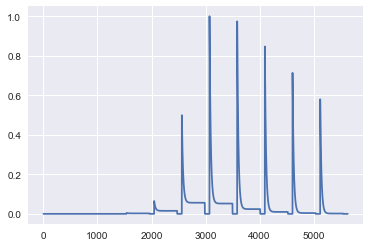

In [9]:
plt.plot(example_df.values[0])



In [10]:
def plot_pca(pc_df,show_type=False):
    
    fig, ax = plt.subplots(1,3,figsize=(18, 6))
    ax = ax.flatten()

    which_pcs = [(1,2),(1,3),(2,3)]
    total_pc_channels = len(pc_df.index.values)
    
    colors = ['r','b','y','g']

    for ax_id, (x_axis,y_axis) in enumerate(which_pcs):
        x_pc = 'PC '+str(x_axis)
        y_pc = 'PC '+str(y_axis)

        ax[ax_id].scatter(pc_df.loc[:, x_pc],
                   pc_df.loc[:, y_pc],
                   c = 'r', s = 50,
                   alpha=0.8,edgecolors='gray')


        ax[ax_id].set_xlabel(x_pc)
        ax[ax_id].set_ylabel(y_pc)

    return fig, ax



In [8]:
def compute_protocol_pca(pca_df,protocol_id=None,drop_cols=['Model_ID','Protocol_ID','Channel_Type'],plots=False):
    
    if protocol_id:
        final_pca_df = pca_df[pca_df['Protocol_ID']==protocol_id]
    else:
        final_pca_df = pca_df
        
        

    # drop label columns
    temp_df = final_pca_df.copy()
    if drop_cols:
        df = temp_df.drop(labels=drop_cols,axis='columns')
    else:
        df = temp_df

    # separating out the features
    x = df.loc[:].values

    # choose number of components for pca
    pca = PCA(n_components=.99) # choose n_components s.t. 99% of variance is retained

    # standardize the features 
    scaled_x = StandardScaler().fit_transform(x) 
    pcs = pca.fit_transform(scaled_x) 
    num_pcs = pcs.shape[1] # get the number of components for pca
#     print(num_pcs)
    
    # redo if PCs (more so for the sake of my code than any technical reason)
    if num_pcs<3:
        # choose number of components for pca
        pca = PCA(n_components=3) # choose n_components s.t. 99% of variance is retained

        # standardize the features 
        scaled_x = StandardScaler().fit_transform(x) 
        pcs = pca.fit_transform(scaled_x) 
        num_pcs = pcs.shape[1] # get the number of components for pca
        
    
    scores = pca.score_samples(scaled_x) # Does this need to be the original data?


    # create pca DataFrame
    pc_columns = ['PC '+str(i+1) for i in range(num_pcs)]

    pc_df = pd.DataFrame(data = pcs, columns = pc_columns)


    # toss back in the labels from before - I force all to be type str
    if drop_cols:
        for col_label in drop_cols:
            pc_df[col_label] = pd.Series([str(i) for i in final_pca_df[col_label].values])

    
    if plots:
        df = pd.DataFrame({'variance':pca.explained_variance_ratio_,
                 'PC':pc_columns})


        # Plotting the raw Explained Variance
        fig = plt.figure(figsize=(12,4))

        # first plot
        sns.barplot(x='PC',y="variance", 
                   data=df, color="c")

        plt.ylabel('Total Variance (%)')
        plt.xticks(rotation='vertical')
        plt.title(protocol_id)
        plt.show()
    
    
    return pc_df, pca, pcs, scores



## Voltage-gated calcium current clusters

In [12]:
norm_cav_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5625,5626,5627,5628,5629,5630,5631,Model_ID,Protocol_ID,Channel_Type
0,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,NMLCH000014,ACTIVATION,Cav
1,0.024395,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,...,0.159074,0.159078,0.159082,0.159086,0.159090,0.159094,0.159098,NMLCH000014,DEACTIVATION,Cav
2,0.002124,0.883331,1.000000,0.996459,0.985908,0.975225,0.964542,0.954000,0.943549,0.933185,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,NMLCH000014,INACTIVATION,Cav
3,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,...,0.000007,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,NMLCH000017,ACTIVATION,Cav
4,-0.025858,-0.000005,-0.000005,-0.000006,-0.000006,-0.000006,-0.000006,-0.000007,-0.000007,-0.000007,...,0.167979,0.167990,0.168002,0.168014,0.168025,0.168037,0.168048,NMLCH000017,DEACTIVATION,Cav


### Need to get num_pcs that explain 99% of the variance

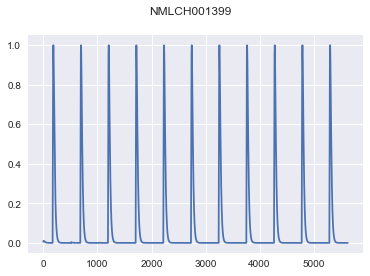

In [13]:
which_trace = 14
plt.plot(norm_cav_df[norm_cav_df['Protocol_ID']=='INACTIVATION'].iloc[which_trace].values[:-3])
plt.suptitle(norm_cav_df[norm_cav_df['Protocol_ID']=='INACTIVATION']['Model_ID'].iloc[which_trace]);

ACTIVATION


/Users/vrhaynes/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


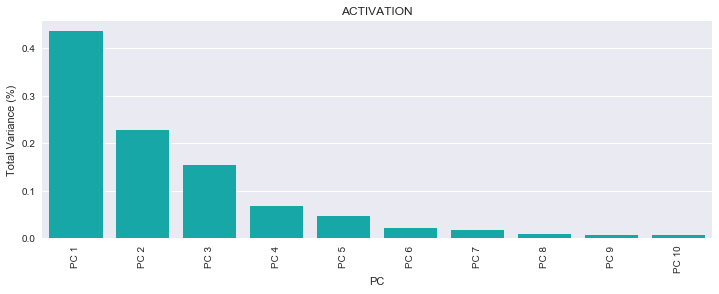

DEACTIVATION


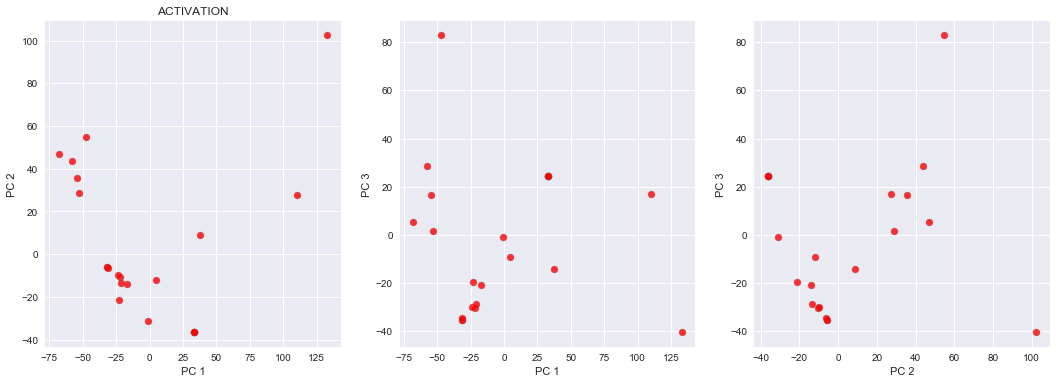

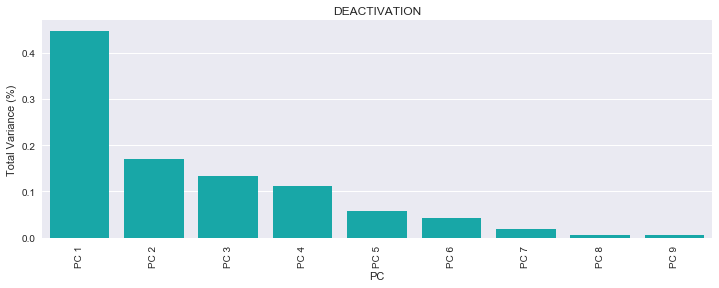

INACTIVATION


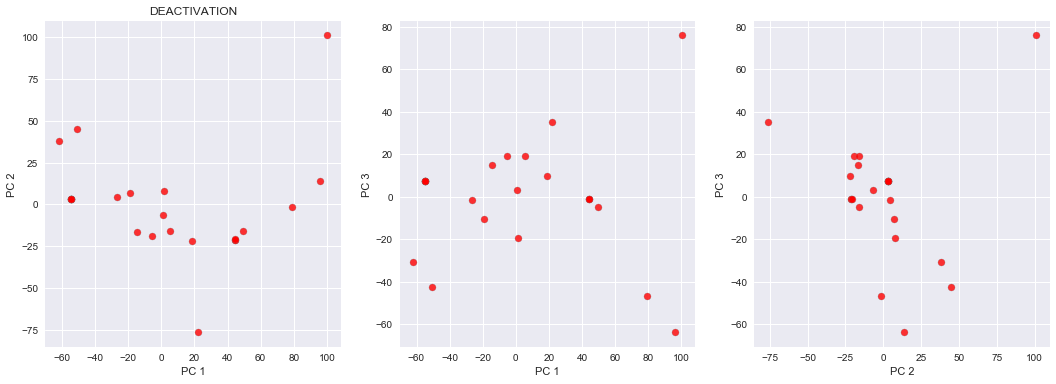

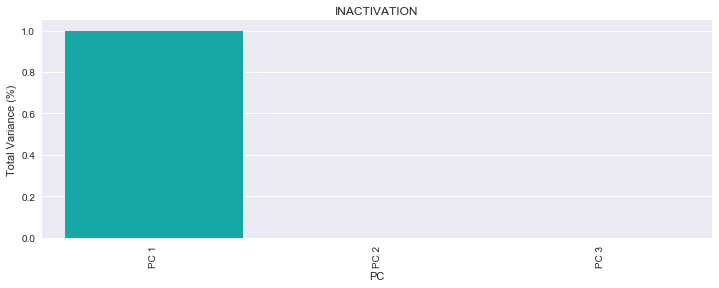

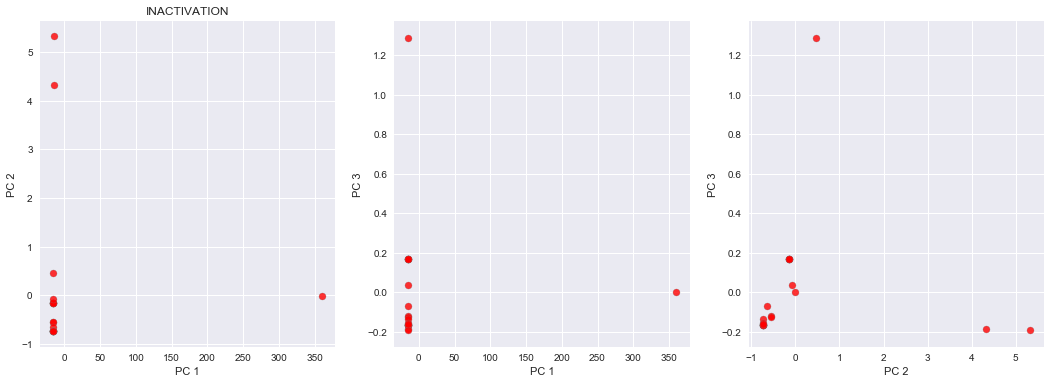

In [14]:
pca_df = norm_cav_df # perform on normalized responses
protocols = ['ACTIVATION','DEACTIVATION','INACTIVATION']

pc_dfs = []
pcas = []
pcs = []

# compute pca and plot
for protocol_id in protocols:
    print(protocol_id)
    pc_df, pca, pc, _ = compute_protocol_pca(pca_df,protocol_id,plots=True)
    
    # collect all
    pc_dfs.append(pc_df)
    pcas.append(pca)
    pcs.append(pc)
    
    
    fig, ax = plot_pca(pc_df=pc_df)
    
    ax[0].set_title(protocol_id)
    
    

In [ ]:
for protocol_id, pc_df, pca, pc in zip(protocols,pc_dfs,pcas,pcs):
    
    pc_columns = ['PC '+str(i+1) for i in range(num_pcs)]
    
    df = pd.DataFrame({'variance':pca.explained_variance_ratio_,
             'PC':pc_columns})


    # Plotting the raw Explained Variance
    fig = plt.figure(figsize=(12,4))

    # first plot
    sns.barplot(x='PC',y="variance", 
               data=df, color="c")

    plt.ylabel('Total Variance (%)')
    plt.xticks(rotation='vertical')
    plt.title(protocol_id)
    plt.show()
    
    

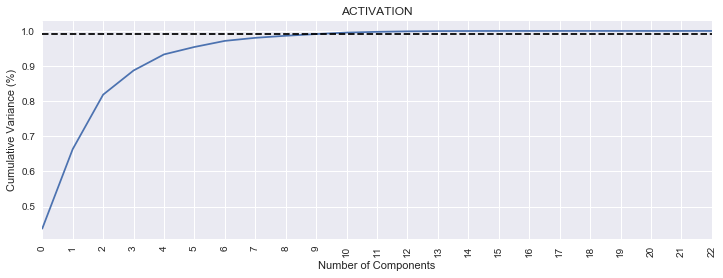

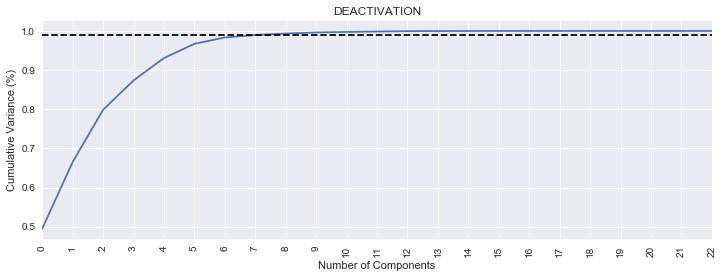

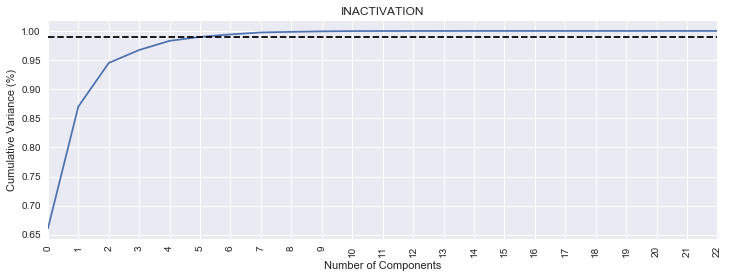

In [24]:
desired_num_pcs = []

for protocol_id, pc_df, pca, pc in zip(protocols,pc_dfs,pcas,pcs):

    #Plotting the Cumulative Summation of the Explained Variance
    fig = plt.figure(figsize=(12,4))

    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.plot(0.99*np.ones_like(np.cumsum(pca.explained_variance_ratio_)),'k--')

    # clean plot
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance (%)') #for each component
    plt.xlim([0,num_pcs-1])
    plt.xticks(range(num_pcs),rotation='vertical')
    plt.title(protocol_id)

    plt.show()
    
    # get num_pcs that satisfy criterion for explained_variance_ratio
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    criterion = .99
    criterion_met = np.where(cumsum>criterion)[0][0]
    
    desired_num_pcs.append(criterion_met)
    
#     print(np.cumsum(pca.explained_variance_ratio_)[9]) # activation num_pcs
#     print(np.cumsum(pca.explained_variance_ratio_)[8]) # deactivation num_pcs
#     print(np.cumsum(pca.explained_variance_ratio_)[6]) # inactivation num_pcs

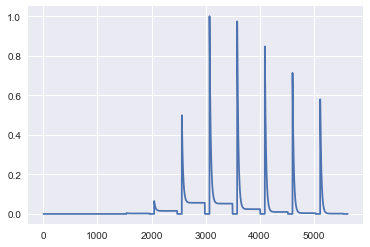

In [32]:
plt.plot(norm_cav_df.loc[0].values[:-3]);

## Adjusted number of PCs

In [106]:
pca_df = norm_cav_df
    
final_pca_df = pca_df[pca_df['Protocol_ID']=='ACTIVATION']

# drop label columns
temp_df = final_pca_df.copy()


df = temp_df.drop(labels=['Model_ID','Protocol_ID','Channel_Type'],axis='columns')
    
#     # separating out the features



#    

#     # standardize the features
#     
#     pcs = pca.fit_transform(x)
#     scores = pca.score_samples(x)


#     # create pca DataFrame
#     pc_columns = ['PC '+str(i+1) for i in range(num_pcs)]

#     pc_df = pd.DataFrame(data = pcs, columns = pc_columns)


#     # toss back in the labels from before - I force all to be type str
#     for col_label in ['Model_ID','Protocol_ID','Channel_Type']:
#         pc_df[col_label] = pd.Series([str(i) for i in final_pca_df[col_label].values])
    
#     return pc_df, pca, pcs, scores




In [107]:
x = df.loc[:].values

In [108]:
pca = PCA(n_components=9)

In [109]:
x = StandardScaler().fit_transform(x)

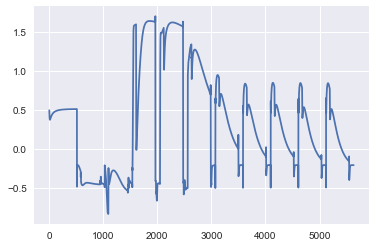

In [110]:
plt.plot(x[8,:]) # these need to be between 0 and 1... go back to data wrangling and fix this!!!
                 # What needs to happen is that each trace is normalized and flipped before appended!

In [ ]:
pc_dfs[2].tail()

In [ ]:
score_samples[2] # with dimension = number of channel models

Normalize the score samples by the standard deviation for a each protocol

In [ ]:
all_condition_scores = []

for i, (score_vector,protocol_id) in enumerate(zip(score_samples,protocols)):
    
    condition_scores = score_vector/np.std(score_vector)
    all_condition_scores.append(condition_scores)

    

final_score_vector = np.array(all_condition_scores).T
    

In [ ]:
# append all score vectors together and normalize to do pca again (if necesary)
columns = ['ACTIVATION','DEACTIVATION','INACTIVATION']
protocol_scores_df = pd.DataFrame(columns=columns)

for col_i, col in enumerate(columns):
    protocol_scores_df[col] = pd.Series(final_score_vector[:,col_i])
    
    
df = cav_pca_df[cav_pca_df['Protocol_ID']=='ACTIVATION']
    
channel_models = df.Model_ID.values
channel_types = df.Channel_Type.values

protocol_scores_df['Model_ID'] = pd.Series(channel_models)
protocol_scores_df['Channel_Type'] = pd.Series(channel_types)



In [ ]:
protocol_scores_df.head()



In [7]:
def normalize_scores(scores_df,num_identifiers=2):
    '''
        
    '''
    
    vector_length = len(scores_df.columns.values)-num_identifiers

    for  i in scores_df.index.values:
        
        scores = scores_df.iloc[i][0:vector_length].values
        
        max_score = np.max(scores)  
        norm_scores = (scores/max_score).tolist()
        
        for j in range(num_identifiers):
            this_identifier = scores_df.columns.values[-(num_identifiers-j)]
            norm_scores.append(scores_df.iloc[i][this_identifier])

        # operates IN PLACE
        scores_df.iloc[i] = norm_scores

        

In [ ]:
normalize_scores(scores_df=protocol_scores_df)



In [ ]:
# final score vector to use as samples for hierarchical clustering
cav_scores_df = protocol_scores_df.copy()



In [ ]:
cav_total_scores = scores

In [ ]:
norm_cav_df.head()

In [5]:
# load everything
filename = os.path.join(path2save,'norm_cav_responses.csv')
norm_cav_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'norm_ih_responses.csv')
norm_ih_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'norm_kca_responses.csv')
norm_kca_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'norm_kv_responses.csv')
norm_kv_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'norm_nav_responses.csv')
norm_nav_df = pd.read_csv(filename,index_col=0)




# Automated ICG scoring

<u>Notes:</u>
 > - Modeled current responses are not forced to be positive but near zero for baseline voltage clamp. I think this is causing problems.

In [6]:
def compute_icg_scores(norm_responses_df,protocols=['ACTIVATION','DEACTIVATION','INACTIVATION'],num_identifiers=3):
    '''
        Skipped first normalization. Include that afterward. Every channel response is reduced to a
        3-dimensional score vector (1 point per protocol or 3 PCs). 
    
    '''
    #### Step 0) Normalize responses
    # done already but will add to this function later
    
    #### STEP 1) Perform PCA with number PCs to retain 99% explained variance
    pca_df = norm_responses_df.copy() # perform on normalized responses

    pc_dfs = []
    pcas = []
    pcs = []
    score_samples = []

    # compute pca and plot
    for protocol_id in protocols:
        pc_df, pca, pc, scores = compute_protocol_pca(pca_df,protocol_id)

        # collect all
        pc_dfs.append(pc_df)
        pcas.append(pca)
        pcs.append(pc)
        score_samples.append(scores)
        
        
    
    #### STEP 2) Normalize condition score vectors (create one score vector per model per protocol)
    final_score_vector = [] # contains all scores = the log-likelihood of samples

    # iterate over protocols
    for i, (score_vector,protocol_id) in enumerate(zip(score_samples,protocols)):

        # normalize the protocol-specific scores by dividing each protocol by std of entries
        condition_scores = score_vector/np.std(score_vector)
        final_score_vector.append(condition_scores) # combined
    
    
    
    
    # !--- this may be wrong below. Is this supposed to be a matrix or a vector
    
    #### Step 3) Combine all condition vectors
    final_score_mat = np.array(final_score_vector).T
    
    # dataframe to store score vectors in
    columns = protocols
    protocol_scores_df = pd.DataFrame(columns=columns)

    for col_i, col in enumerate(columns):
        protocol_scores_df[col] = pd.Series(final_score_mat[:,col_i])
        
            

    
    #### Step 5) Perform PCA again to get final score vector for each model (3 PCs)
    final_pc_df, final_pca, final_pcs, final_scores = compute_protocol_pca(protocol_scores_df,drop_cols=None)

    
    # template from original response dataframe
    df = norm_responses_df[norm_responses_df['Protocol_ID']=='ACTIVATION']

    
    channel_models = df.Model_ID.values
    channel_types = df.Channel_Type.values
    
    # final score vector should be the same length as the number of models  
    final_scores_df = final_pc_df.copy()
    final_scores_df['Model_ID'] = pd.Series(channel_models)
    final_scores_df['Channel_Type'] = pd.Series(channel_types)
    
    
#     # normalize and return
#     normalize_scores(scores_df=protocol_scores_df)

#     # final score vector to use as samples for hierarchical clustering
#     total_scores_df = protocol_scores_df.copy()


    return final_scores_df

In [16]:
norm_cav_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5625,5626,5627,5628,5629,5630,5631,Model_ID,Protocol_ID,Channel_Type
0,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,NMLCH000014,ACTIVATION,Cav
1,0.024395,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,...,0.159074,0.159078,0.159082,0.159086,0.159090,0.159094,0.159098,NMLCH000014,DEACTIVATION,Cav
2,0.002124,0.883331,1.000000,0.996459,0.985908,0.975225,0.964542,0.954000,0.943549,0.933185,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,NMLCH000014,INACTIVATION,Cav
3,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,...,0.000007,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,NMLCH000017,ACTIVATION,Cav
4,-0.025858,-0.000005,-0.000005,-0.000006,-0.000006,-0.000006,-0.000006,-0.000007,-0.000007,-0.000007,...,0.167979,0.167990,0.168002,0.168014,0.168025,0.168037,0.168048,NMLCH000017,DEACTIVATION,Cav


In [19]:
cav_scores_df = compute_icg_scores(norm_responses_df=norm_cav_df)

# save final scores
filename = os.path.join(path2save,'final_scores_cav.csv')
cav_scores_df.to_csv(filename)



In [281]:
cav_scores_df.tail()

,PC 1,PC 2,PC 3,Model_ID,Channel_Type
19,3.196889,-0.237138,-1.086194,NMLCH001586,Cav
20,1.304104,-0.383077,-1.053360,NMLCH001591,Cav
21,0.349779,-0.393160,-0.412675,NMLCH001598,Cav
22,0.016496,1.444460,0.046052,NMLCH001607,Cav
23,1.706735,-0.405474,0.162174,NMLCH001632,Cav


In [20]:
ih_scores_df = compute_icg_scores(norm_responses_df=norm_ih_df)

# save final scores
filename = os.path.join(path2save,'final_scores_ih.csv')
ih_scores_df.to_csv(filename)



In [ ]:
kca_scores_df = compute_icg_scores(norm_responses_df=norm_kca_df)

# save final scores
filename = os.path.join(path2save,'final_scores_kca.csv')
kca_scores_df.to_csv(filename)


In [21]:
kv_scores_df = compute_icg_scores(norm_responses_df=norm_kv_df)

# save final scores
filename = os.path.join(path2save,'final_scores_kv.csv')
kv_scores_df.to_csv(filename)



In [22]:
nav_scores_df = compute_icg_scores(norm_responses_df=norm_nav_df)

# save final scores
filename = os.path.join(path2save,'final_scores_nav.csv')
nav_scores_df.to_csv(filename)


<hr>

## Start Here

In [9]:
# load everything
filename = os.path.join(path2save,'final_scores_cav.csv')
cav_scores_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'final_scores_ih.csv')
ih_scores_df = pd.read_csv(filename,index_col=0)

# filename = os.path.join(path2save,'norm_kca_responses.csv')
# norm_kca_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'final_scores_kv.csv')
kv_scores_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'final_scores_nav.csv')
nav_scores_df = pd.read_csv(filename,index_col=0)





In [10]:
# A function for plotting 3-dimensional data
def plot3d(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*data.T)
    minn,maxx = data.min(),data.max()
    ax.set_xlim(minn,maxx)
    ax.set_ylim(minn,maxx)
    ax.set_zlim(minn,maxx)

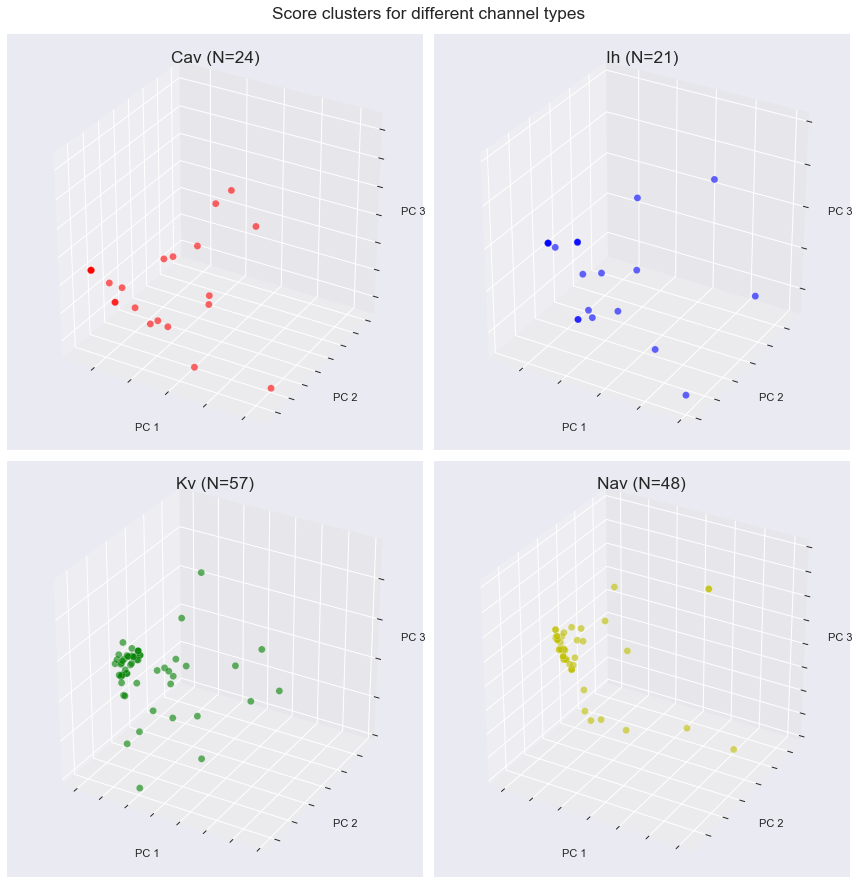

In [11]:
dfs = [cav_scores_df,ih_scores_df,kv_scores_df,nav_scores_df]
titles = ['Cav','Ih','Kv','Nav']
colors = ['r','b','g','y']

# show 3D scatter for each of the channel types
fig = plt.figure(figsize=(12,12))


for i, df in enumerate(dfs):

    ax = fig.add_subplot(2,2,i+1, projection='3d')

    xs = df['PC 1']
    ys = df['PC 2']
    zs = df['PC 3']

    ax.scatter(xs, ys, zs, s=50, c=colors[i], alpha=0.6, edgecolors='w')


    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    num_models = len(xs)
    ax.set_title(titles[i]+' (N=%s)' %num_models,size='xx-large')


fig.tight_layout()
fig.suptitle('Score clusters for different channel types',y=1.02,size='xx-large')

filename = 'specific_clusters'
path2file = os.path.join(path2images,filename)
plt.savefig(path2file,bbox_inches='tight')

## Regular PCA clustering visualization

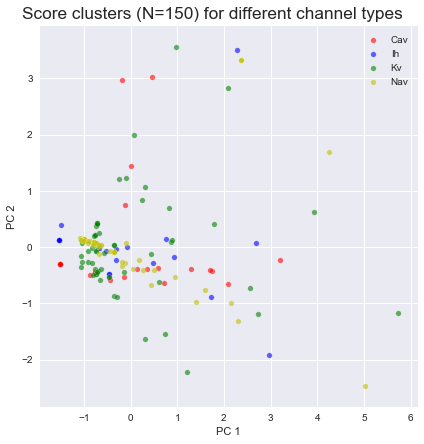

In [12]:
dfs = [cav_scores_df,ih_scores_df,kv_scores_df,nav_scores_df]
titles = ['Cav','Ih','Kv','Nav']
colors = ['r','b','g','y']

# show 3D scatter for each of the channel types
fig = plt.figure(figsize=(6,6))

num_models = 0

for i, df in enumerate(dfs):


    xs = df['PC 1']
    ys = df['PC 2']
    zs = df['PC 3']

    plt.scatter(xs, ys, s=30, c=colors[i], alpha=0.6, edgecolors='w')


    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(titles)

    num_models += len(xs)
    

fig.tight_layout()
fig.suptitle('Score clusters (N=%s) for different channel types' %num_models,y=1.02,size='xx-large')

filename = 'all_clusters'
path2file = os.path.join(path2images,filename)
plt.savefig(path2file,bbox_inches='tight')

## t-SNE visualization

In [10]:
from sklearn.manifold import TSNE

In [11]:
# join all final score vectores for t-SNE viz
all_scores_df = pd.DataFrame(columns=cav_scores_df.columns.values.tolist())

for df in dfs:
    
    join_frames = [all_scores_df,df]
    all_scores_df = pd.concat(join_frames,ignore_index=True)
    
score_data = all_scores_df.values[:,:3].astype('float64')

In [21]:
print(np.isinf(score_data).any())
print(np.isnan(score_data).any())

False
False


In [13]:
score_data.shape # (n_samples,n_features)

(150, 3)

Run <b>channel_tsne_vis.py</b>

## Dendrogram visualizations

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [14]:
filename = os.path.join(path2save,'channel_tags.csv')
channel_tags_df = pd.read_csv(filename,index_col=0)

In [15]:
channel_tags_df.head()

,Model_ID,Model_Name,Filename
0,NMLCH000001,Ih Hyperpolarization Activated Cation,hd.nml
1,NMLCH000002,IA A Type Potassium Channel for Distal Dendrites,kad.nml
2,NMLCH000003,IA A Type Potassium,kap.nml
3,NMLCH000004,KDr Delayed Rectifier Potassium,kdr.nml
4,NMLCH000005,Na Sodium,na3.nml


/Users/vrhaynes/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/vrhaynes/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


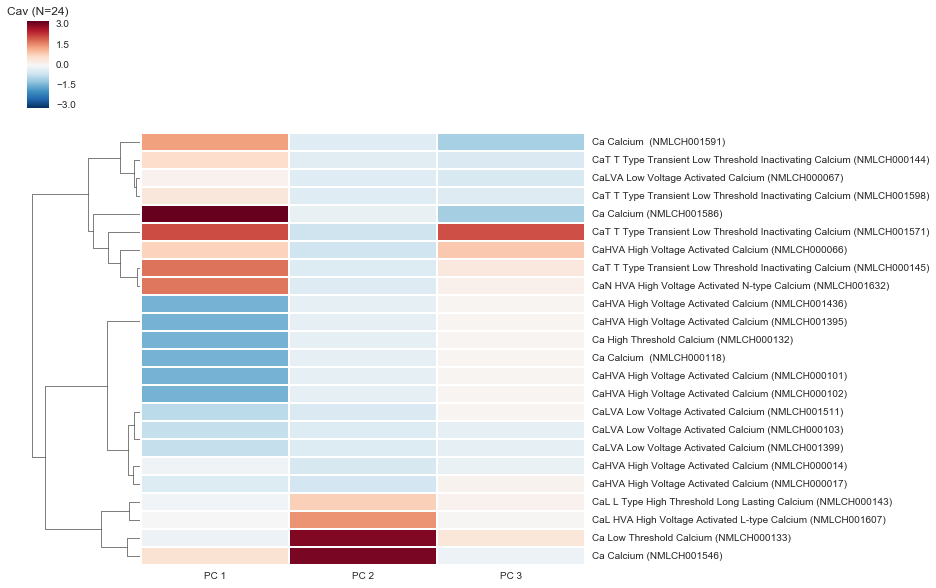

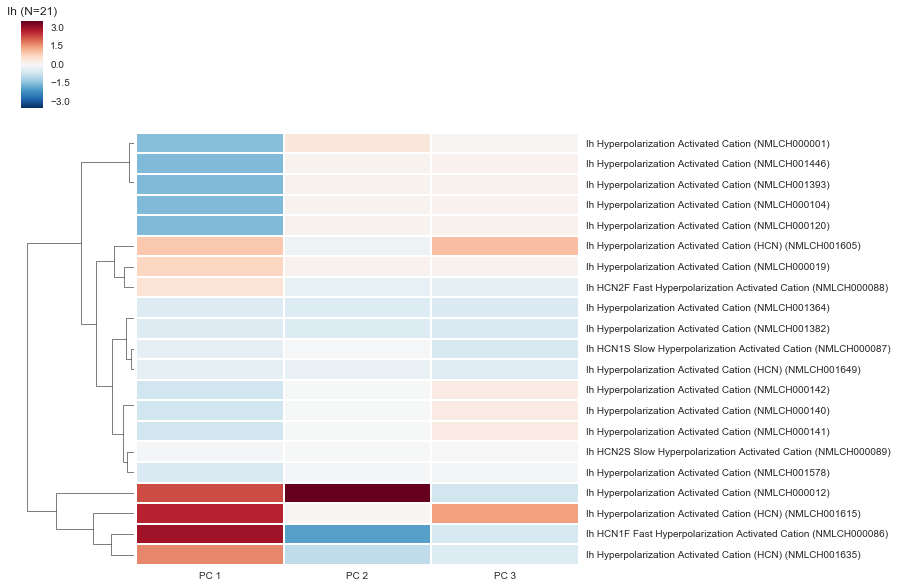

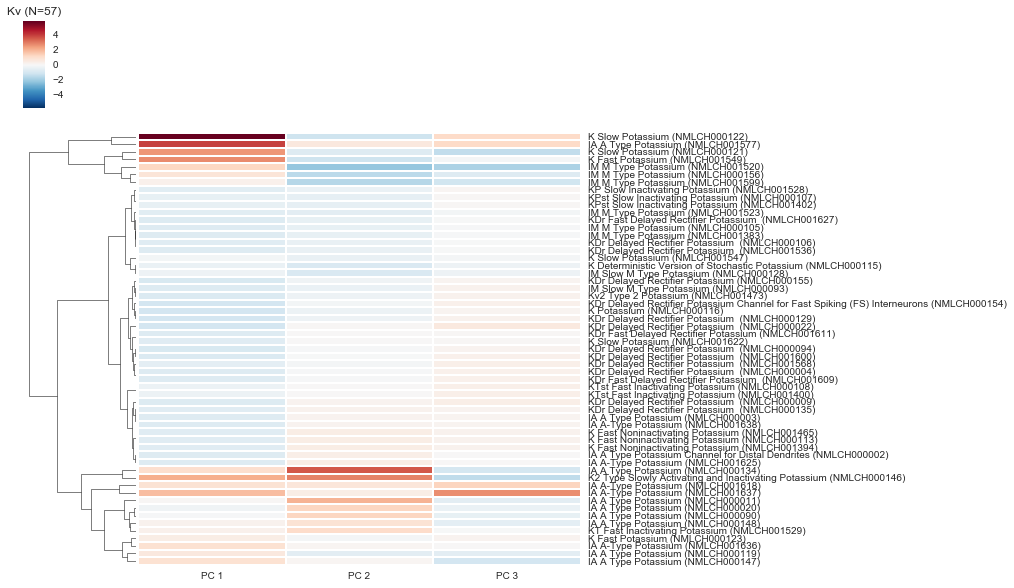

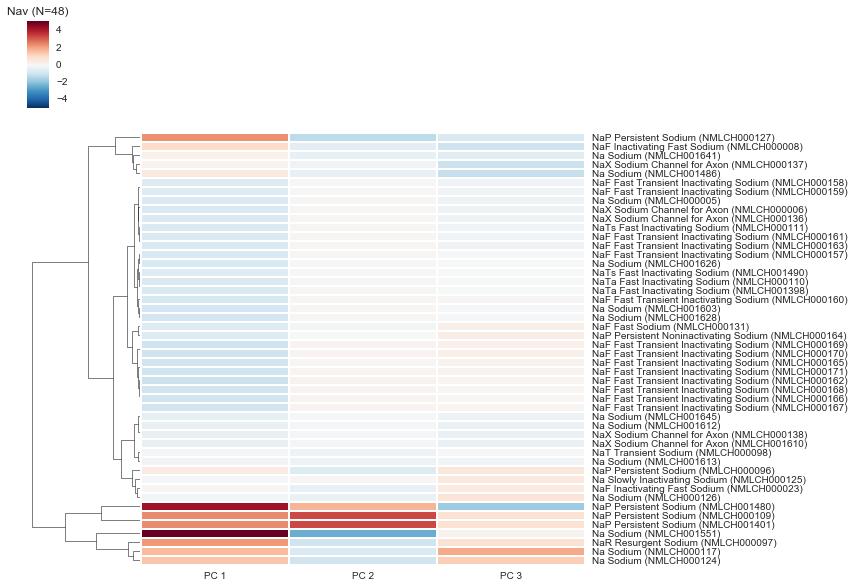

In [16]:
dfs = [cav_scores_df,ih_scores_df,kv_scores_df,nav_scores_df]
titles = ['Cav','Ih','Kv','Nav']

dendrograms = []

for i, df in enumerate(dfs):
    
    fig = plt.figure(figsize=(16,14),dpi=300)

    temp_df = df.copy()
    models = temp_df.pop('Model_ID')
    model_names = channel_tags_df[channel_tags_df['Model_ID'].isin(models)]['Model_Name'].values.tolist()
    channel = temp_df.pop('Channel_Type')
    
    # Calculate the distance between each sample (linkage_matrix)
    link = 'ward'
    Z = linkage(temp_df,link) # default = 'ward'
    
    leaves = []
    
    for nmldb_id, name in zip(models,model_names):
        leaves.append(name + ' ('+ nmldb_id + ')')

    
    clm = sns.clustermap(temp_df, # inherits from above -- metric='Euclidean',method='ward',
                         row_linkage=Z,
                         linewidths=1,
                         col_cluster=False,
                         yticklabels=leaves)
    

    
    
    plt.setp(clm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    
#     plt.tight_layout()
    plt.title(titles[i]+' (N=%s)' %len(models))
    
    filename = titles[i]+'_clustermap_'+link+'_link'
    path2file = os.path.join(path2images,filename)
    plt.savefig(path2file,bbox_inches='tight')
    

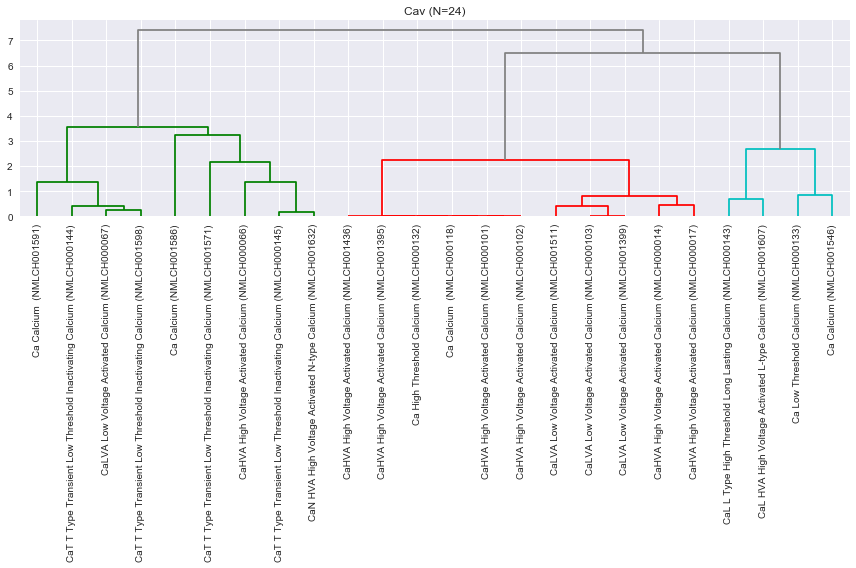

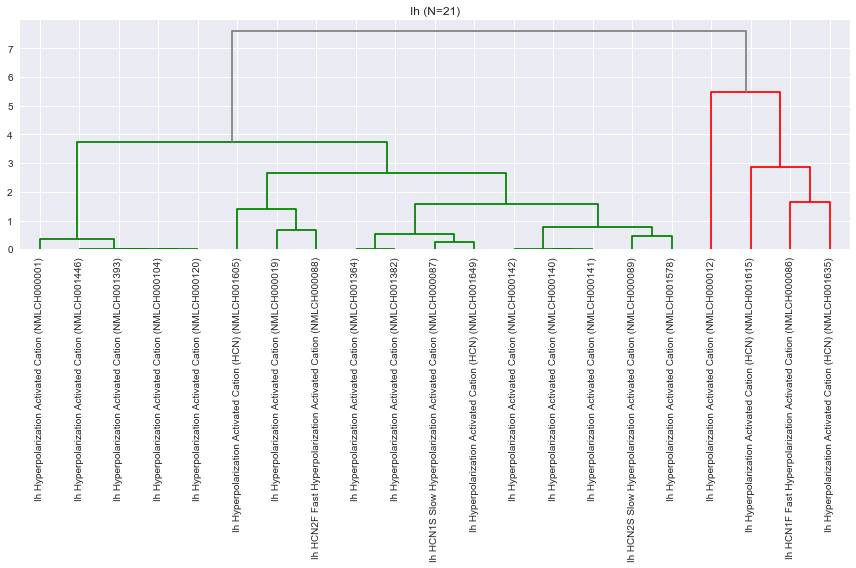

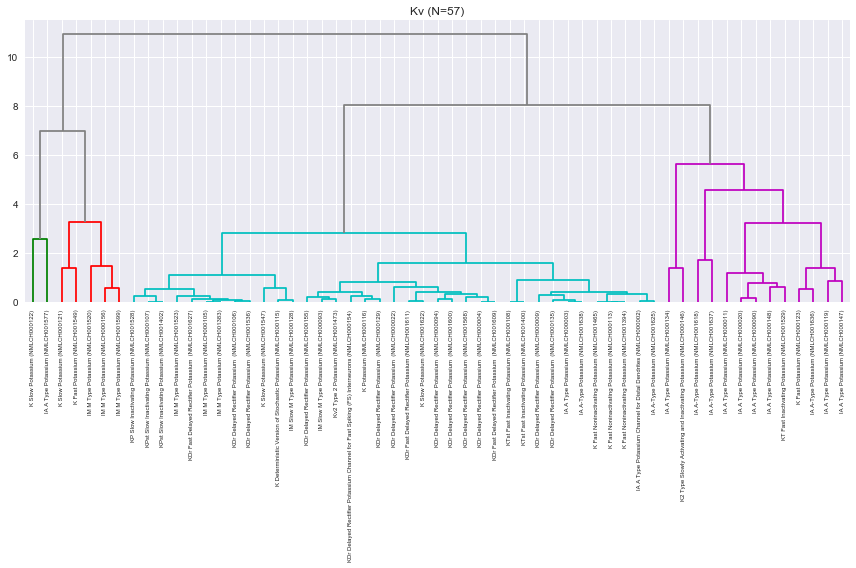

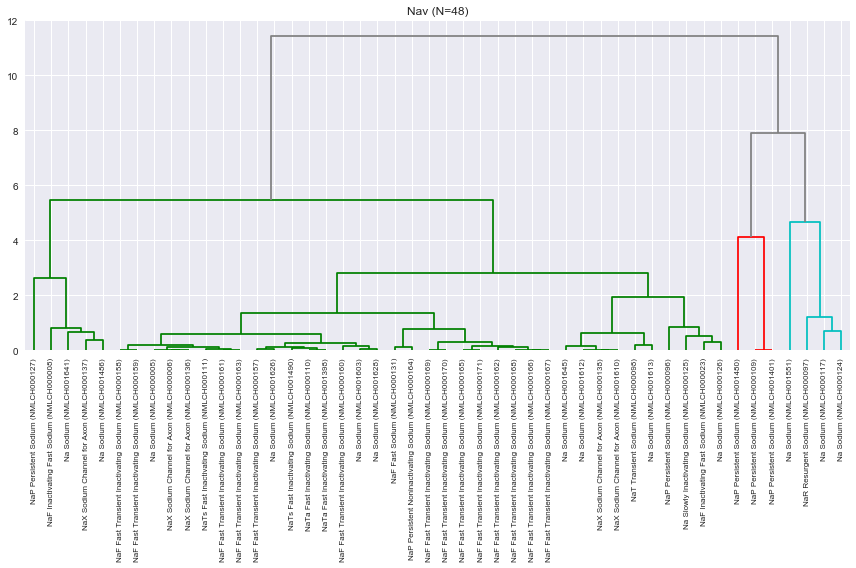

In [17]:
dfs = [cav_scores_df,ih_scores_df,kv_scores_df,nav_scores_df]
titles = ['Cav','Ih','Kv','Nav']
thresholds = [6,6,6,6]

dendrograms = []

for i, df in enumerate(dfs):
    
    fig = plt.figure(figsize=(12,8))

    temp_df = df.copy()
    models = temp_df.pop('Model_ID')
    model_names = channel_tags_df[channel_tags_df['Model_ID'].isin(models)]['Model_Name'].values.tolist()
    channel = temp_df.pop('Channel_Type')
    
    # Calculate the distance between each sample (linkage_matrix)
    link = 'ward'
    Z = linkage(temp_df,link)
    
    leaves = []
    
    for nmldb_id, name in zip(models,model_names):
        leaves.append(name + ' ('+ nmldb_id + ')')

    # Make the dendro
    dend = dendrogram(Z, labels=leaves, 
                      leaf_rotation=90, orientation="top", 
                      color_threshold=thresholds[i], above_threshold_color='grey')
    
    dendrograms.append(dend)
    
    
    plt.title(titles[i]+' (N=%s)' %len(models))
    plt.tight_layout()
    
    filename = titles[i]+'_dend_'+link+'_link'
    path2file = os.path.join(path2images,filename)
    plt.savefig(path2file,
                dpi=300,
                bbox_inches='tight')
    
    plt.show()

# Exemplar traces for different cluster groups

In [331]:
norm_cav_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5625,5626,5627,5628,5629,5630,5631,Model_ID,Protocol_ID,Channel_Type
0,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,NMLCH000014,ACTIVATION,Cav
1,0.024395,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,...,0.159074,0.159078,0.159082,0.159086,0.159090,0.159094,0.159098,NMLCH000014,DEACTIVATION,Cav
2,0.002124,0.883331,1.000000,0.996459,0.985908,0.975225,0.964542,0.954000,0.943549,0.933185,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,NMLCH000014,INACTIVATION,Cav
3,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,...,0.000007,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,NMLCH000017,ACTIVATION,Cav
4,-0.025858,-0.000005,-0.000005,-0.000006,-0.000006,-0.000006,-0.000006,-0.000007,-0.000007,-0.000007,...,0.167979,0.167990,0.168002,0.168014,0.168025,0.168037,0.168048,NMLCH000017,DEACTIVATION,Cav


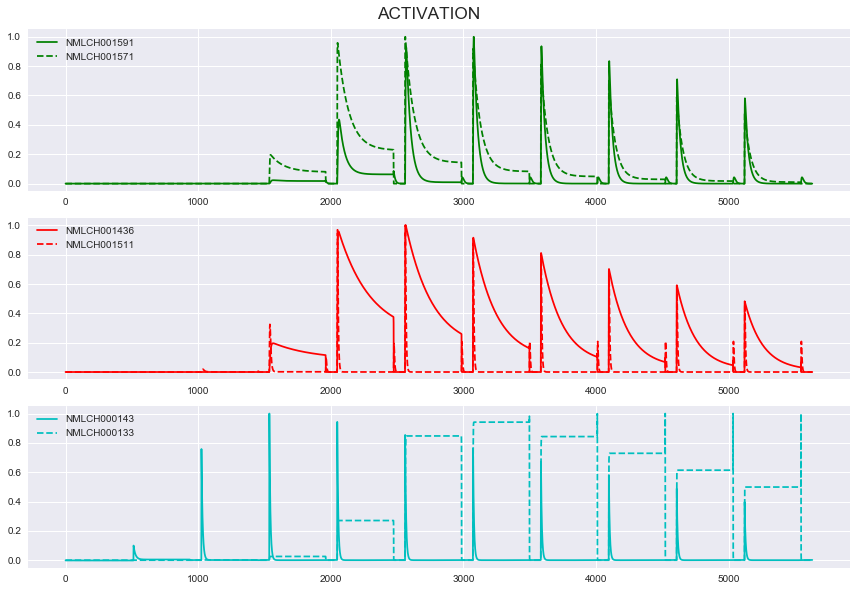

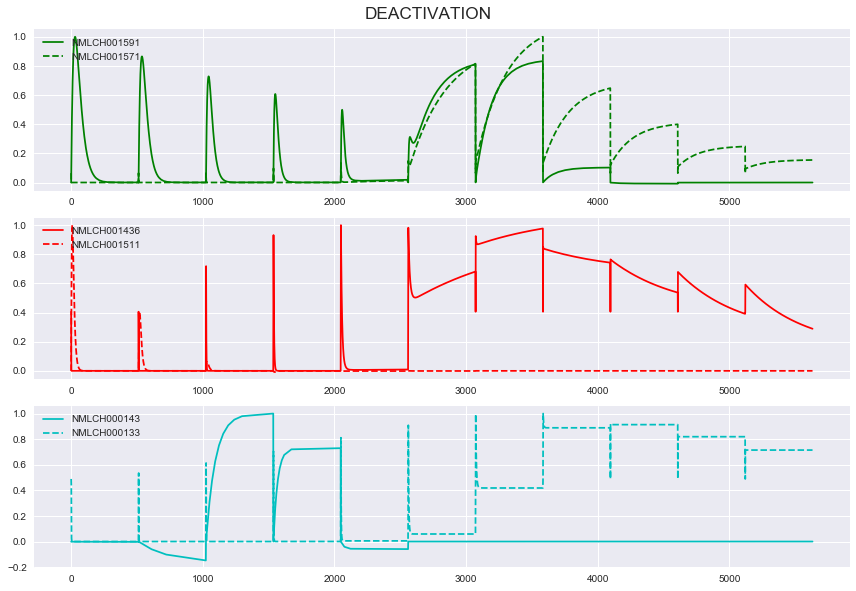

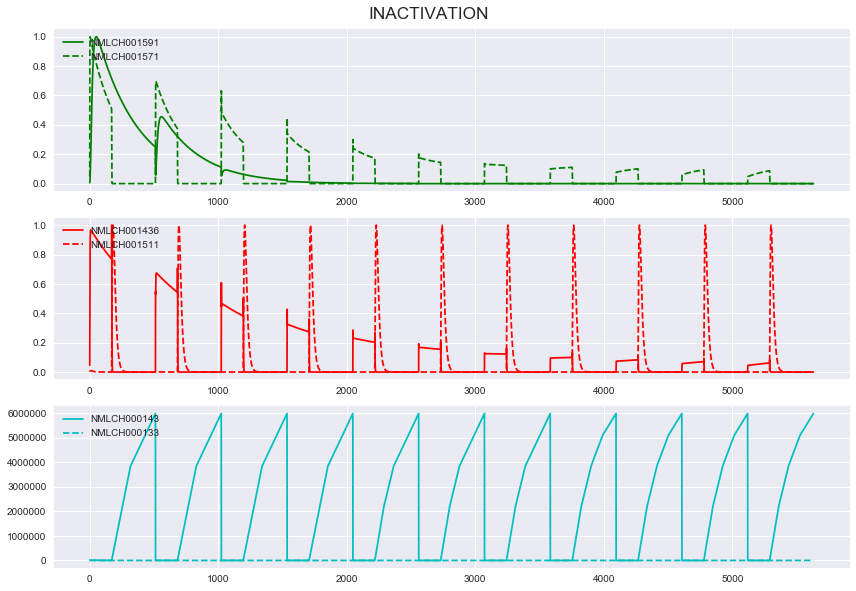

In [369]:
# Cav channels
num_cav_clusters = 3
cluster_colors = ['g','r','c']
cav_exemplars = [['NMLCH001591','NMLCH001571'],
                 ['NMLCH001436','NMLCH001511'],
                 ['NMLCH000143','NMLCH000133']]

protocols=['ACTIVATION','DEACTIVATION','INACTIVATION']


for protocol_id in protocols:
    
    fig, ax = plt.subplots(3,1,figsize=(12,8))

    for i, (color, exemplar_list) in enumerate(zip(cluster_colors,cav_exemplars)):

        num_traces = len(exemplar_list)

        traces_df = norm_cav_df[norm_cav_df['Model_ID'].isin(exemplar_list)]

        model_ids = traces_df.pop('Model_ID')
        channel_types = traces_df.pop('Channel_Type')

        protocol_traces_df = traces_df[traces_df['Protocol_ID']==protocol_id]
        protocols = protocol_traces_df.pop('Protocol_ID')

        plot_traces = protocol_traces_df.values

        for j, trace in enumerate(plot_traces):
            if j == 0:
                ax[i].plot(trace,color)
            else:
                color = color+'--'
                ax[i].plot(trace,color)
                
        ax[i].legend(exemplar_list,loc='upper left')
            
        fig.suptitle(protocol_id,y=1.02,size='xx-large')
        fig.tight_layout()
        
        
    filename = 'cav_'+protocol_id+'_exemplars'
    path2file = os.path.join(path2images,filename)
    plt.savefig(path2file,bbox_inches='tight')
        


## !-- NOTE: MISSED WHOLE MODELS AND INDIVIDUAL TRACES IN THE NEGATIVE DEFLECTION TEST THAT LED TO THIS

## !- TODO: CREATE VALID NEGATIVE DEFLECTION TEST

In [360]:
norm_cav_df[norm_cav_df['Model_ID']=='NMLCH000133']

,0,1,2,3,4,5,6,7,8,9,...,5625,5626,5627,5628,5629,5630,5631,Model_ID,Protocol_ID,Channel_Type
27,-0.001614,-0.001620,-0.001627,-0.001633,-0.001639,-0.001645,-0.001651,-0.001657,-0.001662,-0.001668,...,1.548165e-03,1.557261e-03,1.566356e-03,1.575452e-03,1.584547e-03,1.593643e-03,1.602738e-03,NMLCH000133,ACTIVATION,Cav
28,-0.001402,-0.001404,-0.001406,-0.001409,-0.001411,-0.001414,-0.001416,-0.001419,-0.001421,-0.001423,...,-2.003478e-06,-1.671777e-06,-1.340075e-06,-1.008374e-06,-6.766728e-07,-3.449716e-07,-1.327036e-08,NMLCH000133,DEACTIVATION,Cav
29,15082.266249,14996.735516,14911.204784,14825.674051,14740.143318,14654.612586,14569.081853,14483.551120,14398.020387,14312.489655,...,5.930888e+06,5.939375e+06,5.947862e+06,5.956349e+06,5.964835e+06,5.973322e+06,5.981809e+06,NMLCH000133,INACTIVATION,Cav


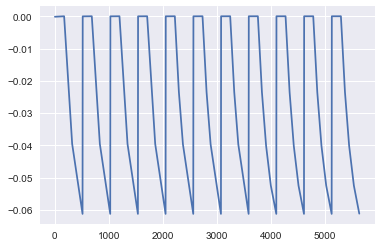

In [368]:
plt.plot(cav_responses_df.iloc[29].values[:-3])

In [ ]:
# Ih channels
num_ih_clusters = 2
cluster_colors = ['g','r']
ih_examplars = [['NLMCH000001','NMLCH000088'],
                ['NMLCH001615','NMLCH001635']]

In [ ]:
# Kv channels
num_clusters = 3
kv_examplars = [['NLMCH000122','NMLCH000156'],
                ['NMLCH000128','NMLCH000094'],
                ['NMLCH000134','NMLCH000119']]

In [ ]:
# Nav channels
num_clusters = 3
nav_examplars = [['NLMCH000008','NMLCH000169'],
                 ['NMLCH001401','NMLCH000109'],
                 ['NMLCH001551','NMLCH000124']]

<hr>

# OLD STUFF